In [1]:
import pandas as pd
import numpy as np

In [3]:
df_item = pd.read_csv("item.csv")

In [5]:
df_item.head()

,nickname,level,subclass,preset_number,equipment_part,equipment_slot,item_name,str_total,dex_total,int_total,...,attack_power_starforce,magic_power_starforce,armor_starforce,speed_starforce,jump_starforce,special_ring_level,soul_name,soul_option,main_stat_type,bonus_stat_total
0,0005,288,패스파인더,1,귀고리,귀고리,지옥의 불꽃,7,66,7,...,0,0,0,0,0,0,NaN,NaN,NaN,0
1,0005,288,패스파인더,1,기계 심장,기계 심장,페어리 하트,49,49,49,...,0,0,0,0,0,0,NaN,NaN,NaN,0
2,0005,288,패스파인더,1,눈장식,눈장식,블랙빈 마크,45,49,6,...,0,0,0,0,0,0,NaN,NaN,NaN,0
3,0005,288,패스파인더,1,렐릭,보조무기,포텐셜 렐릭,3,3,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0
4,0005,288,패스파인더,1,망토,망토,타일런트 케이론 클록,98,66,50,...,0,0,0,0,0,0,NaN,NaN,NaN,0


In [15]:
df_item.columns

Index(['nickname', 'level', 'subclass', 'preset_number', 'equipment_part',
       'equipment_slot', 'item_name', 'str_total', 'dex_total', 'int_total',
       ...
       'attack_power_starforce', 'magic_power_starforce', 'armor_starforce',
       'speed_starforce', 'jump_starforce', 'special_ring_level', 'soul_name',
       'soul_option', 'main_stat_type', 'bonus_stat_total'],
      dtype='object', length=103)

In [31]:
df_item['subclass'].unique

<bound method Series.unique of 0              패스파인더
1              패스파인더
2              패스파인더
3              패스파인더
4              패스파인더
             ...    
895029    아크메이지(불,독)
895030    아크메이지(불,독)
895031    아크메이지(불,독)
895032    아크메이지(불,독)
895033    아크메이지(불,독)
Name: subclass, Length: 895034, dtype: object>

In [17]:
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
# df = pd.read_csv("/mnt/data/item.csv")

# 2. 직업별 주스탯 사전 정의
main_stat_map = {
    "STR": ["아델", "소울마스터", "데몬어벤져", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저", "데몬슬레이어", "미하일", "블래스터", "은월", "스트라이커", "캐논마스터", "아크", "바이퍼"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터", "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스", "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "ALL": ["제논"]  # STR/DEX/LUK 모두 사용하는 경우
}

# 3. 주스탯 컬럼 결정 함수
def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:
            return stat
    return "UNK"

df_item["main_stat_type"] = df_item["subclass"].apply(get_main_stat)

# 4. main_stat_total 생성
df_item["main_stat_total"] = df_item.apply(lambda row: row[f"{row['main_stat_type'].lower()}_total"]
                                 if row["main_stat_type"] in ["STR", "DEX", "INT", "LUK"]
                                 else row[["str_total", "dex_total", "luk_total"]].sum(), axis=1)

# 5. 스타포스 평균
starforce_cols = ['attack_power_starforce', 'magic_power_starforce', 'armor_starforce',
                  'speed_starforce', 'jump_starforce']
df_item['starforce_sum'] = df_item[starforce_cols].sum(axis=1)

# 6. 장비군 그룹 지정
def equipment_group(slot):
    if slot in ['무기', '보조무기', '엠블렘']:
        return "weapon"
    elif slot in ['모자', '상의', '하의', '신발', '장갑', '망토']:
        return "armor"
    elif slot in ['귀고리', '펜던트', '반지', '벨트', '눈장식', '얼굴장식']:
        return "accessory"
    elif "심장" in slot or "기계" in slot:
        return "heart"
    else:
        return "other"

df_item["equip_group"] = df_item["equipment_slot"].apply(equipment_group)

# 7. 캐릭터 단위 feature 집계
agg_funcs = {
    "main_stat_total": "sum",
    "bonus_stat_total": "sum",
    "starforce_sum": "sum",
}

# 그룹화: 캐릭터 단위
char_features = df_item.groupby("nickname").agg(agg_funcs).reset_index()

# 8. 피벗테이블로 장비군별 스탯 추출
pivot = df_item.pivot_table(index="nickname", 
                       columns="equip_group", 
                       values="main_stat_total", 
                       aggfunc="sum", 
                       fill_value=0).reset_index()

# 9. 통합 벡터 구성
final_df = pd.merge(char_features, pivot, on="nickname")

# 10. 결측치 채움
final_df = final_df.fillna(0)

# 결과 확인
print(final_df.head())

  nickname  main_stat_total  bonus_stat_total  starforce_sum  accessory  \
0     0005             1133                 0            596        389   
1   002번출구             2752                 0           4625        741   
2      00우             3935                 0           8278       1019   
3  00우즈키00             2830                 0           5930        710   
4     0101             1597                 0           1723        402   

   armor  heart  other  weapon  
0    432     49     76     187  
1   1370     49    201     391  
2   1877     49    326     664  
3   1624     49    265     182  
4    826     19    172     178  


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = final_df.drop(columns=["nickname"])

# 클러스터링
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(X)

# 실루엣 점수 계산
score = silhouette_score(X, clusters)
print(f"📈 실루엣 점수: {score:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


📈 실루엣 점수: 0.4740


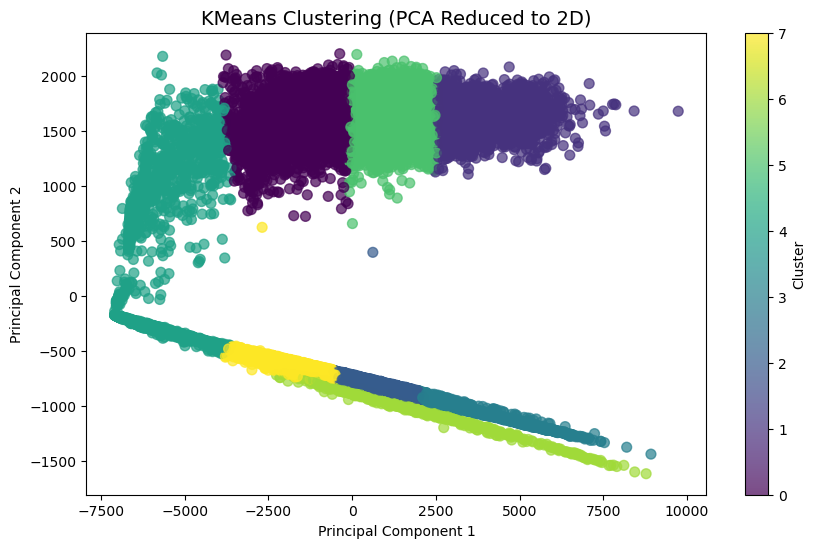

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA로 2D로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 클러스터별로 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.title("KMeans Clustering (PCA Reduced to 2D)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

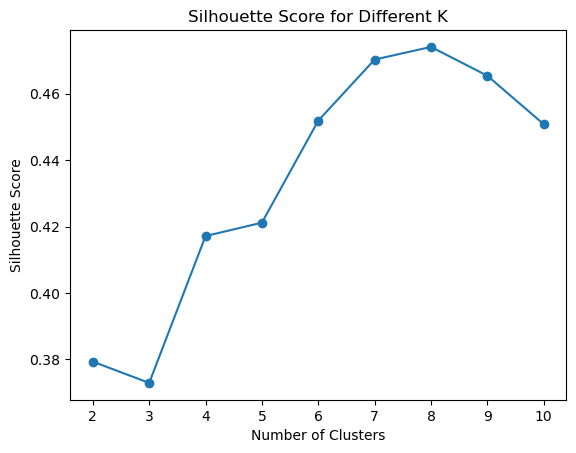

In [25]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sil_scores = []
k_range = range(2, 11)  # 군집 수를 2에서 10까지 시도

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    score = silhouette_score(X, clusters)
    sil_scores.append(score)

# 실루엣 점수 시각화
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score for Different K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# -----------------------
# [1] 데이터 로드 및 전처리
# -----------------------
df_item = pd.read_csv("item.csv")  # 파일 경로에 맞게 수정

# 주스탯 분류 기준
main_stat_map = {
    "STR": ["아델", "소울마스터", "데몬어벤져", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저", "데몬슬레이어", "미하일", "블래스터", "은월", "스트라이커", "캐논마스터", "아크", "바이퍼"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터", "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스", "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "ALL": ["제논"]
}

def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:
            return stat
    return "UNK"

df_item["main_stat_type"] = df_item["subclass"].apply(get_main_stat)

# 주스탯 합산
df_item["main_stat_total"] = df_item.apply(
    lambda row: row[f"{row['main_stat_type'].lower()}_total"]
    if row["main_stat_type"] in ["STR", "DEX", "INT", "LUK"]
    else row[["str_total", "dex_total", "luk_total"]].sum(), axis=1)

# 스타포스 총합
starforce_cols = ['attack_power_starforce', 'magic_power_starforce', 'armor_starforce',
                  'speed_starforce', 'jump_starforce']
df_item['starforce_sum'] = df_item[starforce_cols].sum(axis=1)

# 장비군 그룹핑
def equipment_group(slot):
    if slot in ['무기', '보조무기', '엠블렘']:
        return "weapon"
    elif slot in ['모자', '상의', '하의', '신발', '장갑', '망토']:
        return "armor"
    elif slot in ['귀고리', '펜던트', '반지', '벨트', '눈장식', '얼굴장식']:
        return "accessory"
    elif "심장" in slot or "기계" in slot:
        return "heart"
    else:
        return "other"

df_item["equip_group"] = df_item["equipment_slot"].apply(equipment_group)

# -----------------------
# [2] 캐릭터 단위 Feature 생성
# -----------------------

# 기본 합산
char_features = df_item.groupby("nickname").agg({
    "main_stat_total": "sum",
    "bonus_stat_total": "sum",
    "starforce_sum": "sum"
}).reset_index()

# 주스탯 대비 추옵 비율
char_features["main_to_bonus_ratio"] = (
    char_features["bonus_stat_total"] / (char_features["main_stat_total"] + 1e-6)
)

# 장비군별 편차
def std_by_group(df, group_name):
    return df[df["equip_group"] == group_name].groupby("nickname")["main_stat_total"].std()

for g in ["armor", "weapon", "accessory", "heart"]:
    std_col = std_by_group(df_item, g).rename(f"{g}_main_stat_std")
    char_features = pd.merge(char_features, std_col, on="nickname", how="left")

char_features = char_features.fillna(0)

# -----------------------
# [3] 표준화 및 KNN 모델 적합
# -----------------------

feature_cols = [
    "main_stat_total",
    "bonus_stat_total",
    "starforce_sum",
    "main_to_bonus_ratio",
    "armor_main_stat_std",
    "weapon_main_stat_std",
    "accessory_main_stat_std",
    "heart_main_stat_std"
]

X = char_features[feature_cols].copy()
nicknames = char_features["nickname"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
knn.fit(X_scaled)

# -----------------------
# [4] 유사 유저 추천
# -----------------------

# 예시: 특정 캐릭터와 유사한 캐릭터 5명
target_nickname = "다효"  # 본인의 캐릭터 닉네임
target_idx = char_features[char_features["nickname"] == target_nickname].index[0]

distances, indices = knn.kneighbors([X_scaled[target_idx]])

print(f"\n[{target_nickname}] 와 유사한 캐릭터:")
for i, idx in enumerate(indices[0]):
    if idx == target_idx:
        continue  # 자기 자신 제외
    print(f"{i}. {nicknames[idx]} (거리: {distances[0][i]:.3f})")



[다효] 와 유사한 캐릭터:
1. 티깝 (거리: 0.509)
2. 블랑카이후 (거리: 0.571)
3. To선인 (거리: 0.624)
4. 따스한라라 (거리: 0.677)
5. 토깽이 (거리: 0.686)


In [35]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette:.3f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.288


In [37]:
print(f"추천된 유저 평균 거리: {distances[0][1:].mean():.4f}")

추천된 유저 평균 거리: 0.6132
